In [1]:
import sys
sys.path.append(r"d:\VSCode\re-assistant")

In [2]:
import os
import sys
import pytz
import redis
import asyncio
from datetime import datetime
from rich.console import Console
from rich.markdown import Markdown
from lib.utils import AGENT_MODEL, SYSTEM_PROMPT
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END
from lib.db.db_service import ThreadService
# from lib.db.db_conn import conn
from datetime import datetime
from lib.load_data import df
from rapidfuzz import fuzz
import re

Command-line environment detected. Using local data file.
Loading email metadata from: d:\VSCode\re-assistant\lib\data\full_mails.jsonl
Successfully loaded 11688 records for metadata.
Connecting to ChromaDB Vector Store...
Successfully connected to ChromaDB collection.


In [3]:
import nest_asyncio
import polars as pl
from langchain.tools import tool
nest_asyncio.apply()

In [ ]:
import polars as pl

df = pl.read_csv('hf://datasets/espejelomar/code_search_net_python_10000_examples/codesearchnet_10000_python_examples.csv')

In [99]:
print(df[0]['func_code_url'])
# print(df[0])

shape: (1,)
Series: 'func_code_url' [str]
[
	"https://github.com/getsentry/l…
]


In [93]:
temp_df = df.clone()

temp_df = temp_df.with_columns(
    [
        pl.col("from").map_elements(lambda x: fuzz.partial_ratio(x.lower(), "2g Projects Team")).alias("cross_check")
    ]
)

true_rows = temp_df.filter(pl.col('cross_check') > 60)
# print(true_rows)
print(true_rows[2]['id'])
print(true_rows[2]['from'])

shape: (1,)
Series: 'id' [str]
[
	"18901978208d88b5"
]
shape: (1,)
Series: 'from' [str]
[
	"Projects <projects@sree-soluti…
]


C:\Users\User\AppData\Local\Temp\ipykernel_23792\986337465.py:3: MapWithoutReturnDtypeWarning: 'return_dtype' of function python_udf must be set

A later expression might fail because the output type is not known. Set return_dtype=pl.self_dtype() if the type is unchanged, or set the proper output data type.
  temp_df = temp_df.with_columns(


In [ ]:
# -------------------- CONFIG --------------------
console = Console()
IST = pytz.timezone("Asia/Kolkata")
today_date = datetime.now(IST).strftime("%B %d, %Y")

In [ ]:
# -------------------- INITIALIZE --------------------
DATABASE_URL = os.getenv("DATABASE_URL")
REDIS_URL = os.getenv("REDIS_URL")

In [ ]:
# Initialize Redis client
if REDIS_URL:
    redis_client = redis.from_url(REDIS_URL, decode_responses=True)
print(redis_client, 'redis')

<redis.client.Redis(<redis.connection.ConnectionPool(<redis.connection.Connection(decode_responses=True,username=default,password=cfyFn0nS1xS4QCc4zAnbodLpSqQAxsXM,host=redis-15302.c212.ap-south-1-1.ec2.redns.redis-cloud.com,port=15302)>)>)> redis


In [ ]:
def format_date(d):
    if isinstance(d, datetime):
        return d.strftime('%Y-%m-%d %H:%M:%S')
    elif isinstance(d, str):
        return d
    return 'N/A'

In [ ]:
def normalize_email_field(*values):
    """Normalize one or more email fields into clean lowercase emails."""
    normalized_emails = []
    
    for value in values:
        # Polars Series safe check
        if isinstance(value, pl.Series):
            if value.is_empty():
                continue
            value = value.to_list()

        if not value:
            continue

        if isinstance(value, list):
            for v in value:
                cleaned = re.sub(r'[\"\'<>]', '', v)
                normalized_emails.append(cleaned.strip().lower())
        else:
            cleaned = re.sub(r'[\"\'<>]', '', value)
            normalized_emails.append(cleaned.strip().lower())

    return normalized_emails

In [ ]:
# Test the normalization
print(normalize_email_field("\"2gians@2getherments.com\" <2gians@2getherments.com>", "\"arun.bunny@gmail.com\" <arun.bunny@gmail.com>", "\"balaji.kr88@gmail.com\" <balaji.kr88@gmail.com>", "\"hspavankumar@yahoo.com\" <hspavankumar@yahoo.com>", "\"janardhanthcm@gmail.com\" <janardhanthcm@gmail.com>", "\"myuppalsri@gmail.com\" <myuppalsri@gmail.com>", "\"rajabsvb@yahoo.com\" <rajabsvb@yahoo.com>", "\"rankumar2020@gmail.com\" <rankumar2020@gmail.com>", "\"shashidharreddy9@yahoo.com\" <shashidharreddy9@yahoo.com>", "\"sureshgupth@gmail.com\" <sureshgupth@gmail.com>", "\"svkp049@gmail.com\" <svkp049@gmail.com>", "\"vaasureddy28@gmail.com\" <vaasureddy28@gmail.com>", "\"y.n.v.nithin@gmail.com\" <y.n.v.nithin@gmail.com>"))

['2gians@2getherments.com 2gians@2getherments.com', 'arun.bunny@gmail.com arun.bunny@gmail.com', 'balaji.kr88@gmail.com balaji.kr88@gmail.com', 'hspavankumar@yahoo.com hspavankumar@yahoo.com', 'janardhanthcm@gmail.com janardhanthcm@gmail.com', 'myuppalsri@gmail.com myuppalsri@gmail.com', 'rajabsvb@yahoo.com rajabsvb@yahoo.com', 'rankumar2020@gmail.com rankumar2020@gmail.com', 'shashidharreddy9@yahoo.com shashidharreddy9@yahoo.com', 'sureshgupth@gmail.com sureshgupth@gmail.com', 'svkp049@gmail.com svkp049@gmail.com', 'vaasureddy28@gmail.com vaasureddy28@gmail.com', 'y.n.v.nithin@gmail.com y.n.v.nithin@gmail.com']


In [ ]:
def match_value_in_columns(value, column_value):
    """
    Check if the global `value` matches any entry in `column_value (from, to, cc)`.

    Matching rules:
      1. If `column_value` is a list → check each item.
      2. If `column_value` is a string → check directly.
      3. A match is considered valid if:
            - `sender` is an exact substring, OR
            - fuzzy string similarity (partial_ratio) > 50.
      4. If no match found or input invalid → return False.
    """
    if not isinstance(value, str) or not value:
        return False

    # Case 1: column_value is a list
    if isinstance(column_value, list):
        for e in column_value:
            if value in e or fuzz.partial_ratio(value.lower(), e.lower()) > 60:
                return True
        return False

    # Case 2: column_value is a string
    if isinstance(column_value, str):
        return value in column_value or fuzz.partial_ratio(value.lower(), column_value.lower()) > 60

    return False

In [ ]:
# Normalize the lists to string to apply filters
def normalize_list(lst) -> str:
    normalized = []

    if isinstance(lst, list):
        for i in lst:
            val = normalize_email_field(i)
            if isinstance(val, list):
                normalized.extend(map(str, val))  # flatten if list
            elif val is not None:
                normalized.append(str(val))

    elif lst is not None:
        val = normalize_email_field(lst)
        if isinstance(val, list):
            normalized.extend(map(str, val))
        elif val is not None:
            normalized.append(str(val))

    return ",".join(normalized)

In [ ]:
time_keywords = ["latest", "recent", "current", "newest", "updated", "recently added", "last", "final", "previous", "closing", "last updated", "last seen"]
summary = ["summarise", "summarize", "outline", "condense", "digest", "abstract", "recap", "brief", "shorten", "compress", "synopsize", "review", "gist", "overview", "abridge", "highlight", "capsule", "compendium"]

In [ ]:
# @tool("metadata_filtering_tool", parse_docstring=True)
def metadata_filtering_tool(
    query: str = None,
    sender: str = None,
    recipient: str = None,
    start_date: str = None,
    end_date: str = None,
    subject: str = None,
    threadId: str = None,
    sort_by: str = "date",
    sort_order: str = "desc",
    limit: int = 5
) -> str:
    """
    This tool filter emails based on metadata such as sender, recipient, date range, subject, or thread ID.
    
    Args:
        query (str): The complete user-provided query string in natural language format.
        sender (str or list of str, optional): Filter emails by sender(s). Can be full email address, partial email, or sender names (case-insensitive).
        recipient (str or list of str, optional): Filter emails by recipient(s). Can be full email addresses, partial emails, or recipient names (case-insensitive).
        start_date (str, optional): Filter emails sent on or after this date. Format: 'YYYY-MM-DD' or 'YYYY-MM-DD HH:MM:SS'.
        end_date (str, optional): Filter emails sent on or before this date. Format: 'YYYY-MM-DD' or 'YYYY-MM-DD HH:MM:SS'.
        subject (str, optional): Filter emails containing this keyword in the subject (case-insensitive, partial match supported).
        threadId (str, optional): Filter emails belonging to a specific thread ID.
        sort_by (str, optional): Column to sort the results by. Default is 'date'.
        sort_order (str, optional): Sort order: 'asc' for ascending, 'desc' for descending. Default is 'desc'.
        limit (int, optional): Maximum number of results to return. Default is 10.
    """

    print(f"metadata_filtering_tool is being called {sender}, {recipient}, {start_date}, {end_date}, {subject}, {threadId}, {sort_by}, {sort_order}, {limit}")
    temp_df = df.clone()
    mask = pl.lit(True)

    # --- Sender filter (case-insensitive, matches name or email) ---
    if sender:
        sender = sender.lower()

        # Add a normalized column
        temp_df = temp_df.with_columns([
            pl.col("from").map_elements(normalize_list, return_dtype=str).alias("from_normalized")
        ])

        # Filter rows where the normalized 'from' matches sender
        sender_mask = pl.col("from_normalized").map_elements(lambda x: match_value_in_columns(sender, x), return_dtype=bool)
        mask = mask & sender_mask

    # --- Recipient filter ---
    if recipient:
        recipient = recipient.lower()

        # Normalize 'to' and 'cc' columns which are lists
        temp_df = temp_df.with_columns([
            pl.col("to").map_elements(normalize_list, return_dtype=str).alias("to_normalized"),
            pl.col("cc").map_elements(normalize_list, return_dtype=str).alias("cc_normalized")
        ])

        # Filter rows where any normalized 'to' or 'cc' matches the recipient
        recipient_mask = (
            pl.col("to_normalized").map_elements(lambda x: match_value_in_columns(recipient, x), return_dtype=bool) |
            pl.col("cc_normalized").map_elements(lambda x: match_value_in_columns(recipient, x), return_dtype=bool)
        )
        mask = mask & recipient_mask

    # --- Date filtering (normalize to datetime) ---
    if start_date or end_date:
        temp_df = temp_df.with_columns([
            pl.col("date").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%SZ", strict=False).alias("date_dt")
        ])

    if start_date:
        start_date_dt = datetime.strptime(start_date, "%Y-%m-%d")
        try:
            mask = mask & (pl.col("date_dt") >= start_date_dt)
        except Exception as e:
            return f"Error parsing start_date: {e}"

    if end_date:
        end_date_dt = datetime.strptime(end_date, "%Y-%m-%d")
        try:
            mask = mask & (pl.col("date_dt") <= end_date_dt)
        except Exception as e:
            return f"Error parsing end_date: {e}"
        
    # Apply the mask only once
    temp_df = temp_df.filter(mask)

    # --- Handle empty result ---
    if temp_df.is_empty():
        return "No emails found matching the specified criteria."
    
    # --- Sorting ---
    sort_by = 'date'
    sort_order = 'desc'
    
    ascending = (sort_order.lower() == 'asc')
    if query is not None:
        match_found = any(fuzz.partial_ratio(query.lower(), kw) > 40 for kw in time_keywords)
        if match_found:
            ascending = False

    # Ensure column exists
    if sort_by not in temp_df.columns:
        sort_by = "date"
    
    # Apply sort
    temp_df = temp_df.sort(sort_by, descending=not ascending)

    # --- Total count ---
    total_matches = temp_df.height

    # --- Preview results ---
    results_preview = temp_df.head(limit).select(['threadId', 'from', 'to', 'subject', 'date', 'cc']).to_dicts()
        
    formatted_results = "\n\n---\n\n".join([
        f"threadId: {res.get('threadId', 'N/A')}\n"
        f"From: {res.get('from', 'N/A')}\n"
        f"To: {res.get('to', 'N/A')}\n"
        f"CC: {res.get('cc', 'N/A')}\n"
        f"Subject: {res.get('subject', 'N/A')}\n"
        f"Date: {datetime.fromisoformat(res.get('date')).strftime('%Y-%m-%d %H:%M:%S') if res.get('date') else 'N/A'}"
        for res in results_preview
    ])

    # print(formatted_results, "formatted_results from metadata_filtering_tool")
    return f"Found a total of {total_matches} emails matching the criteria. Here are the {min(limit, total_matches)} most relevant:\n\n{formatted_results}"

In [ ]:
# Sample test
print(metadata_filtering_tool(None, None, "kishore kalagotla"))

metadata_filtering_tool is being called None, kishore kalagotla, None, None, None, None, date, desc, 5
Found a total of 4365 emails matching the criteria. Here are the 5 most relevant:

threadId: 19189b9807202ae8
From: Sankar Narayanan <sankar.narayanan@2getherments.com>
To: ['Rahul Sinha <rahulsinha198@gmail.com>', 'Rama Krishna <ramakrishna@2getherments.com>']
CC: ['Harinath Rao <hari@2getherments.com>', 'Pallavi T <pallavi@2getherments.com>', 'Meena T <meena@2getherments.com>', 'Kishore Kalagotla <kishore.kalagotla@2getherments.com>', 'Customer Communications 2g CX <customer.communications@2getherments.com>', 'Akshata Patil <akshata@2getherments.com>']
Subject: Re: Important Guidelines for Interior Contractors at 2gTula
Date: 2025-07-17 15:15:54

---

threadId: 19189b9807202ae8
From: Rahul Sinha <rahulsinha198@gmail.com>
To: ['Sankar Narayanan <sankar.narayanan@2getherments.com>']
CC: ['Harinath Rao <hari@2getherments.com>', 'Pallavi T <pallavi@2getherments.com>', 'Meena T <meena@2g

In [ ]:
# Define the list of tools the agent can use
tools = [metadata_filtering_tool]
tool_node = ToolNode(tools)

In [ ]:
# -------------------- INITIALIZE THE MODEL --------------------
# Use LangGraph's init_chat_model
model = init_chat_model(model=AGENT_MODEL, temperature=0)
model_with_tools = model.bind_tools(tools)

In [ ]:
# -------------------- HELPER FUNCTIONS --------------------
def call_model(state: MessagesState) -> MessagesState:
    """
    Sends messages to the model and returns the response wrapped in MessagesState format.
    """
    messages = state["messages"]

    response = model_with_tools.invoke(input=messages)
    return {"messages": [response]}

def should_continue(state: MessagesState) -> bool:
    """
    Decides whether to call tools next based on the last model output.
    """
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return 'tools'
    return END

In [ ]:
# Initialize the ThreadService for managing chat threads
# memory = ThreadService(connection=conn, redis_client=redis_client)

In [ ]:
# Define an async function to chat with the agent
async def main():
    # Create a new thread for this chat
    USER_ID = "63f05e7a-35ac-4deb-9f38-e2864cdf3a1d"

    # Check if user already has a thread
    # thread_id = memory.get_last_thread(USER_ID)

    # if thread_id:
    #     print(f"Resuming last thread: {thread_id}")
    # else:
    #     thread_id = memory.create_new_thread(
    #         user_id=USER_ID, 
    #         title="Email's related qns"
    #     )
    #     print(f"Created new thread: {thread_id}")
    #     print(f"New chat started. Thread ID: {thread_id}")

        # Create a LangGraph agent
    builder = StateGraph(MessagesState)
    builder.add_node("call_model", call_model)
    builder.add_node("tools", tool_node)

    # Define edges
    builder.add_edge(START, "call_model")
    builder.add_conditional_edges("call_model", should_continue, ["tools", END])
    builder.add_edge("tools", "call_model")

    # Compile the graph
    email_agent_graph = builder.compile()

    # Loop until the user chooses to quit the chat
    while True:
        # last_20_messages = memory.get_thread_messages(thread_id)

        user_input = input("\nAsk a question about your emails: ")
        if user_input.lower() == 'exit':
            break
 
        initialState = {
            "messages": [
                {"role": "system", "content": SYSTEM_PROMPT.format(today_date=today_date)},
                # *last_20_messages['messages'],
                {"role": "user", "content": user_input}
            ]
        }

        # Use the async stream method of the LangGraph agent to get the agent's answer
        events = email_agent_graph.astream(initialState)
        async for event in events:
            for _, value in event.items():
                if "messages" in value:
                    agent_answer = value["messages"][-1].content

        # memory.put_thread_message(thread_id, [
        #     {"role": "user", "content": user_input},
        #     {"role": "assistant", "content": agent_answer}
        # ])

        # Display the agent's answer
        print("\n--- Final Answer ---")
        console.print(Markdown(agent_answer))
        print("--------------------\n")

In [ ]:
# -------------------- RUN THE AGENT --------------------
if sys.platform == "win32":
    asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())

# Run the main async function
asyncio.run(main())

metadata_filtering_tool is being called deepa, None, None, None, None, None, date, desc, 1
shape: (159, 14)
┌────────────┬────────────┬────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ id         ┆ threadId   ┆ source ┆ date      ┆ … ┆ attachmen ┆ labels    ┆ source_pa ┆ from_norm │
│ ---        ┆ ---        ┆ ---    ┆ ---       ┆   ┆ ts        ┆ ---       ┆ th        ┆ alized    │
│ str        ┆ str        ┆ str    ┆ str       ┆   ┆ ---       ┆ list[str] ┆ ---       ┆ ---       │
│            ┆            ┆        ┆           ┆   ┆ list[stru ┆           ┆ str       ┆ str       │
│            ┆            ┆        ┆           ┆   ┆ ct[4]]    ┆           ┆           ┆           │
╞════════════╪════════════╪════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 18d832a374 ┆ 18cecca882 ┆ gmail  ┆ 2024-02-0 ┆ … ┆ [{"ANGjdJ ┆ ["IMPORTA ┆ raw/gmail ┆ deepa d   │
│ 6e03a8     ┆ 6355ad     ┆        ┆ 7T16:13:0 ┆   ┆ _0ijOIXmW ┆ NT", "CAT ┆ /2024-0

It seems there was a misunderstanding, as the latest email I found was from Debanjan Ray, not Deepa. Here are the  
details of that email:                                                                                             

 • From: Debanjan Ray ]8;id=131670;mailto:ray.debanjan89@gmail.com\ray.debanjan89@gmail.com]8;;\                                                                     
 • To: Sankar Narayanan ]8;id=730453;mailto:sankar.narayanan@2getherments.com\sankar.narayanan@2getherments.com]8;;\, Customer Communications 2g CX                           
   ]8;id=131122;mailto:customer.communications@2getherments.com\customer.communications@2getherments.com]8;;\                                                                        
 • Subject: Unit No: A920: Query: Pending Issues to be addressed                                                   
 • Date: July 11, 2025                                                                                             

Unfortunately, I couldn't find the latest email from Deepa. If you have any other specific requests or need        
assistance with something else, feel free to let me know!

--------------------



In [18]:
from lib.utils import AGENT_MODEL
from langchain.chat_models import init_chat_model
from langgraph.graph import MessagesState, StateGraph, START, END

model = init_chat_model(model=AGENT_MODEL, temperature=0)

In [24]:
from langgraph.prebuilt import ToolNode
from tools.conversation_retriever_tool import conversation_retriever_tool

tools = [conversation_retriever_tool]
tool_node = ToolNode(tools)

In [32]:
def call_model(state: MessagesState) -> MessagesState:
    """
    Sends messages to the model and returns the response wrapped in MessagesState format.
    """
    messages = state['messages']
    response = model_with_tools.invoke(input=messages)
    return {'messages': messages}

In [20]:
def should_continue(state: MessagesState) -> MessagesState:
    """
    Decides whether to call tools next based on the last model output.
    """
    last_message = state['messages'][-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [25]:
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

# Define edges
builder.add_edge(START, "call_model")
builder.add_conditional_edges("call_model", should_continue, ["tools", END])
builder.add_edge("tools", "call_model")


In [26]:
graph = builder.compile()

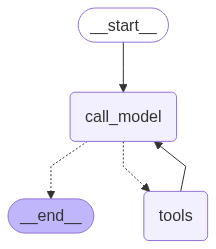

In [27]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))